# Bias Response Curve Experiment

This notebook measures how adding a gender steering vector to GPT-2 Small’s hidden state changes its output.

- Loads GPT-2 Small via TransformerLens
- Computes a gender bias steering vector (“He” vs “She”) at a chosen layer/hook site
- **Sweeps α and injects at inference; reports *logit* differences** Δ = logit(“He”) − logit(“She”)
- **Compares to random and orthogonal directions** (controls)
- **Uses consistent BOS/tokenization and auto-detects target token position**
- Saves plot as `bias_response_curve.png` and prints basic stats

In [ ]:
import json, math, os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

import transformer_lens
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
from transformers import logging

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

## Set device (CUDA if available, else CPU)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load GPT-2 Small Model


In [171]:
logging.enable_progress_bar()
model = HookedTransformer.from_pretrained("gpt2-small")
model.to(device).eval()

print({
    "model_name": model.cfg.model_name,
    "n_layers": model.cfg.n_layers,
    "d_model": model.cfg.d_model,
    "tokenizer": type(model.tokenizer).__name__,
})

/workspace/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
{'model_name': 'gpt2', 'n_layers': 12, 'd_model': 768, 'tokenizer': 'GPT2TokenizerFast'}


## Define Prompts and READ/WRITE Layer


In [209]:
# Prompts
prompt_he  = "He is a doctor."
prompt_she = "She is a doctor."

# Where to inject steer vec
INJECT_LAYER = 3            # 0-indexed -> this is the 4th layer
INJECT_HOOK_SITE = "hook_resid_mid"
INJECT_HOOK_NAME = f"blocks.{INJECT_LAYER}.{INJECT_HOOK_SITE}"

#Where to apply logit lense (READ)
READ_LAYER = 10                
READ_SITE  = "hook_resid_post"  # "residual post FFN at that layer"
READ_HOOK_NAME = f"blocks.{READ_LAYER}.{READ_SITE}"

# BOS policy must be consistent everywhere
PREPEND_BOS = True

# Alpha grid (explore wide; analyze linear subset later if desired)
alphas = np.arange(-10, 10.0, 0.5)

## Tokenize Prompts and Get Token IDs


In [199]:
def first_diff_pos(tok_a: torch.Tensor, tok_b: torch.Tensor) -> int:
    """Return first index where two 1D token tensors differ; fallback to 1 if none."""
    a, b = tok_a[0].tolist(), tok_b[0].tolist()
    upto = min(len(a), len(b))
    for i in range(upto):
        if a[i] != b[i]:
            return i
    return 1  # safe default when using BOS

tokens_he  = model.to_tokens(prompt_he,  prepend_bos=PREPEND_BOS).to(device)
tokens_she = model.to_tokens(prompt_she, prepend_bos=PREPEND_BOS).to(device)

TARGET_POS = first_diff_pos(tokens_he, tokens_she)
he_id  = int(tokens_he[0, TARGET_POS].item())
she_id = int(tokens_she[0, TARGET_POS].item())

print({"TARGET_POS": TARGET_POS, "he_id": he_id, "she_id": she_id})

{'TARGET_POS': 1, 'he_id': 1544, 'she_id': 3347}


## Get Activations for "He" and "She" at the Chosen Layer


In [200]:
with torch.no_grad():
    store = {}

    def save_hook(act, hook):
        store[hook.name] = act.detach().clone()

    # HE
    store.clear()
    _ = model.run_with_hooks(
        tokens_he,
        return_type=None,
        stop_at_layer=INJECT_LAYER + 1,
        fwd_hooks=[(INJECT_HOOK_NAME, save_hook)]
    )
    act_he = store[INJECT_HOOK_NAME][0, TARGET_POS, :].clone().to(device)

    # SHE
    store.clear()
    _ = model.run_with_hooks(
        tokens_she,
        return_type=None,
        stop_at_layer=INJECT_LAYER + 1,
        fwd_hooks=[(INJECT_HOOK_NAME, save_hook)]
    )
    act_she = store[INJECT_HOOK_NAME][0, TARGET_POS, :].clone().to(device)

## Compute Bias, Random, and Orthogonal Vectors


In [201]:
# This sets a small epsilon value to avoid division by zero when normalizing vectors.
eps = 1e-8

v_bias = act_he - act_she
v_bias = v_bias / (v_bias.norm() + eps)

torch.manual_seed(SEED)
v_rand = torch.randn_like(v_bias, device=device)
v_rand = v_rand / (v_rand.norm() + eps)

# Orthogonalize v_rand against v_bias to get v_orth
proj = (v_rand @ v_bias) * v_bias
v_orth = v_rand - proj
v_orth = v_orth / (v_orth.norm() + eps)

## Sweep Alpha Values and Collect Results


In [210]:
def delta_logit_lens(
    prompt: str,
    vector: torch.Tensor,
    alpha: float,
    inject_hook_name: str = INJECT_HOOK_NAME,
    read_hook_name: str   = READ_HOOK_NAME,
    target_pos: int       = TARGET_POS,
    apply_ln_final: bool  = True,   # GPT-2 clean logit lens
) -> float:
    tokens = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)
    cache = {}

    def steer_hook(act, hook):
        act[:, target_pos, :] = act[:, target_pos, :] + alpha * vector
        return act

    def read_hook(act, hook):
        cache["resid"] = act.detach().clone()  # shape: [B, P, d_model]
        return act

    with torch.no_grad():
        _ = model.run_with_hooks(
            tokens,
            return_type=None,
            stop_at_layer=max(INJECT_LAYER, READ_LAYER) + 1,
            fwd_hooks=[(inject_hook_name, steer_hook), (read_hook_name, read_hook)]
        )

    # Keep batch/pos dims so unembed() sees [B, P, d_model]
    resid_3d = cache["resid"][:, target_pos:target_pos+1, :].clone()  # [1,1,d_model]
    if apply_ln_final:
        resid_3d = model.ln_final(resid_3d)  # LN across last dim

    logits_3d = model.unembed(resid_3d)      # [1,1,V]
    logits = logits_3d[0, 0, :]              # [V]

    return float(logits[he_id].item() - logits[she_id].item())

In [211]:
results = {"bias": [], "random": [], "orth": []}
target_prompt = prompt_he  # steer on the "He ..." sentence

for a in alphas:
    results["bias"].append(  delta_logit_lens(target_prompt, v_bias, a) )
    results["random"].append(delta_logit_lens(target_prompt, v_rand, a) )
    results["orth"].append(  delta_logit_lens(target_prompt, v_orth, a) )

print("Δ_logit ranges:", {k: (float(np.min(v)), float(np.max(v))) for k, v in results.items()})

Δ_logit ranges: {'bias': (0.8985390663146973, 1.336684226989746), 'random': (1.1280490159988403, 1.2108646631240845), 'orth': (1.1253151893615723, 1.213135004043579)}


## Plot Results


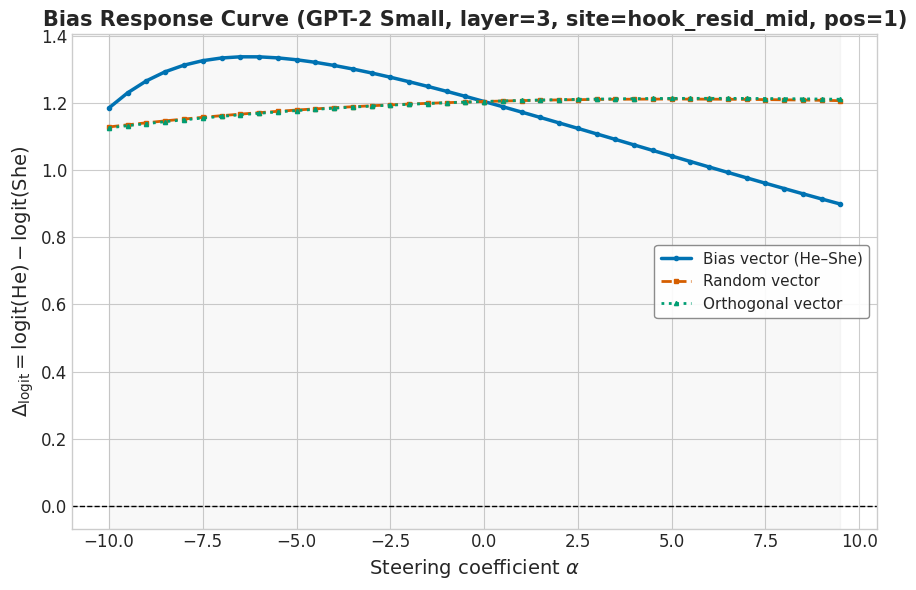

In [212]:
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(9, 6))

bias_color   = "#0072B2"
random_color = "#D55E00"
orth_color   = "#009E73"

ax.plot(alphas, results['bias'],   label='Bias vector (He–She)', color=bias_color,   linewidth=2.5, marker='o', markersize=3)
ax.plot(alphas, results['random'], label='Random vector',         color=random_color, linestyle='--', linewidth=2, marker='s', markersize=3)
ax.plot(alphas, results['orth'],   label='Orthogonal vector',     color=orth_color,   linestyle=':',  linewidth=2, marker='^', markersize=3)

ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_xlabel(r'Steering coefficient $\alpha$', fontsize=14)
ax.set_ylabel(r'$\Delta_{\mathrm{logit}} = \mathrm{logit}(\text{He}) - \mathrm{logit}(\text{She})$', fontsize=14)
ax.set_title(f'Bias Response Curve (GPT-2 Small, layer={INJECT_LAYER}, site={INJECT_HOOK_SITE}, pos={TARGET_POS})',
             fontsize=15, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvspan(min(alphas), max(alphas), color='gray', alpha=0.05)

leg = ax.legend(frameon=True, fontsize=11)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig('bias_response_curve2.png', dpi=300, bbox_inches='tight')
plt.show()

### Utilities (layer-general bias vector + logit probe)


In [ ]:
def compute_bias_vector(layer: int, target_pos: int,
                        prompt_he: str = "He", prompt_she: str = "She",
                        hook_site: str = INJECT_HOOK_SITE):
    hook_name = f"blocks.{layer}.{hook_site}"
    store = {}

    def save_hook(act, hook):
        store[hook.name] = act.detach().clone()

    with torch.no_grad():
        # HE
        store.clear()
        _ = model.run_with_hooks(
            model.to_tokens(prompt_he, prepend_bos=PREPEND_BOS).to(device),
            return_type=None, stop_at_layer=layer + 1,
            fwd_hooks=[(hook_name, save_hook)]
        )
        act_he = store[hook_name][0, target_pos, :].clone()

        # SHE
        store.clear()
        _ = model.run_with_hooks(
            model.to_tokens(prompt_she, prepend_bos=PREPEND_BOS).to(device),
            return_type=None, stop_at_layer=layer + 1,
            fwd_hooks=[(hook_name, save_hook)]
        )
        act_she = store[hook_name][0, target_pos, :].clone()

    v = act_he - act_she
    v = v / (v.norm() + 1e-8)
    return v, hook_name

def delta_logit_alpha(prompt: str, layer: int, target_pos: int,
                      v: torch.Tensor, alpha: float, hook_name: str):
    tokens = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)

    def steer_hook(act, hook):
        act[:, target_pos, :] = act[:, target_pos, :] + alpha * v
        return act

    with torch.no_grad():
        logits = model.run_with_hooks(tokens, fwd_hooks=[(hook_name, steer_hook)], return_type='logits')

    lp = logits[0, target_pos, :]
    return float(lp[he_id].item() - lp[she_id].item())

### Layer sweep (print min/max and a quick slope in linear window)


In [ ]:
prom_he_min = "He"
prom_she_min = "She"

# Choose linear window for slope estimation
alphas_wide = np.arange(-10, 10, 0.5)
alphas_lin  = np.arange(-1.0, 1.01, 0.25)

for L in range(model.cfg.n_layers):
    vL, hookL = compute_bias_vector(L, TARGET_POS, prom_he_min, prom_she_min, hook_site=INJECT_HOOK_SITE)
    y_wide = [delta_logit_alpha(prom_he_min, L, TARGET_POS, vL, a, hookL) for a in alphas_wide]
    y_lin  = [delta_logit_alpha(prom_he_min, L, TARGET_POS, vL, a, hookL) for a in alphas_lin]

    # simple slope via least squares on the linear window
    slope = float(np.polyfit(alphas_lin, y_lin, deg=1)[0])
    print(f"Layer {L:02d}: min={min(y_wide):.4g} max={max(y_wide):.4g} slope@|α|≤1={slope:.4g}")

Layer 00: min=-1.591 max=3.63 slope@|α|≤1=-0.159
Layer 01: min=-1.5 max=0.5615 slope@|α|≤1=-0.111
Layer 02: min=-1.428 max=0.4193 slope@|α|≤1=-0.09731
Layer 03: min=-1.535 max=0.3274 slope@|α|≤1=-0.0951
Layer 04: min=-1.561 max=0.3661 slope@|α|≤1=-0.1027
Layer 05: min=-1.579 max=0.3231 slope@|α|≤1=-0.09894
Layer 06: min=-1.609 max=0.2005 slope@|α|≤1=-0.09685
Layer 07: min=-1.56 max=0.1091 slope@|α|≤1=-0.0877
Layer 08: min=-1.382 max=-0.1356 slope@|α|≤1=-0.06459
Layer 09: min=-1.259 max=-0.1895 slope@|α|≤1=-0.05527
Layer 10: min=-1.082 max=-0.2357 slope@|α|≤1=-0.04263
Layer 11: min=-1.019 max=-0.3081 slope@|α|≤1=-0.03585
